# Employee and Bus Stops

## Context

A company XYZ intends to provide a bus shuttle service that would help its employees commute to the office. The company is based in Mountain View and the shuttle would provide transportation for employees based in San Francisco.

The city of San Francisco has given the company a list of potential bus stops that it may use. However, the company may use no more than 10 of these bus stops for its shuttle service.

The company XYZ is asking you to come up with the **10 most efficient bus stops** that would best serve its employees. Generally speaking, these "efficient" stops would result in the least walking distances between the employees' homes and their respective bus stops. To that end, you were given the following data:
- the list of bus stops provided by the city of San Francisco, `Bus_Stops.csv`
- a list of its employees' home addresses, `Employee_Addresses.csv`

Since trying out all possible combinations of 10 bus stops would take a prohibitively long time, the boss of XYZ has told you that you may simplify the problem and come up with 10 reasonable bus stops that are probably efficient.


## Supplementary Notes

Prior to writing the requested algorithm, you will need to *geocode* the employees' home addresses and bus stops. You may use the [HERE REST APIs](https://developer.here.com/develop/rest-apis) for that purpose. Following are some links to help you in your task:
- To generate a free HereMaps account and an API Key to use for geocoding the addresses:  
    - https://developer.here.com/documentation/identity-access-management/dev_guide/topics/plat-using-apikeys.html
- Sections pertaining to *geocoding* in the documentation:  
    - https://developer.here.com/documentation/geocoder/dev_guide/topics/example-geocoding-free-form.html  
    - https://developer.here.com/documentation/geocoder/dev_guide/topics/example-geocoding-intersection.html
- Programmatically perform GET requests
    - Python: https://realpython.com/python-requests/
    - R: https://www.rdocumentation.org/packages/httr/versions/1.4.4

Note that HereMaps allows a maximum of 1000 requests per day, so it will take more than a single day to do all the geocoding. As a start, you may use all bus stops (~120 stops) and a few hundred employee addresses to start developing your algorithm. Save whatever you geocode so you would not need to geocode it again. Once the geocoding is done for all addresses, run the algorithm one last time and finalize your work.


--------

In [1]:
## Libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import osmnx as ox
import networkx as nx
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import manhattan_distances

# Explore Bus stops data

In [2]:
bus_stops=pd.read_csv("Bus_Stops_with_positions.csv")
bus_stops=bus_stops.drop(columns='Unnamed: 0',axis=1)
bus_stops

,Street_One,Street_Two,lat,lng
0,MISSION ST,ITALY AVE,37.71847,-122.43953
1,MISSION ST,NEW MONTGOMERY ST,37.78745,-122.40050
2,MISSION ST,01ST ST,37.79323,-122.39288
3,MISSION ST,20TH ST,37.75863,-122.41904
4,MISSION ST,FREMONT ST,37.79047,-122.39669
...,...,...,...,...
114,MISSION ST,NIAGARA AVE,37.71558,-122.44172
115,MISSION ST,ACTON ST,37.70880,-122.45276
116,MISSION ST,05TH ST,37.79329,-122.39290
117,MISSION ST,24TH ST,37.75226,-122.41849


In [3]:
bus_stops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119 entries, 0 to 118
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Street_One  119 non-null    object 
 1   Street_Two  119 non-null    object 
 2   lat         119 non-null    float64
 3   lng         119 non-null    float64
dtypes: float64(2), object(2)
memory usage: 3.8+ KB


In [4]:
bus_stops.describe(include='all')

,Street_One,Street_Two,lat,lng
count,119,119,119.000000,119.000000
unique,1,119,NaN,NaN
top,MISSION ST,ITALY AVE,NaN,NaN
freq,119,1,NaN,NaN
mean,NaN,NaN,37.744380,-122.418732
std,NaN,NaN,0.045766,0.051598
min,NaN,NaN,37.356710,-122.452760
25%,NaN,NaN,37.723100,-122.435690
50%,NaN,NaN,37.741750,-122.422080
75%,NaN,NaN,37.774805,-122.415700


All bus stops on Mission ST

<AxesSubplot:xlabel='lng', ylabel='lat'>

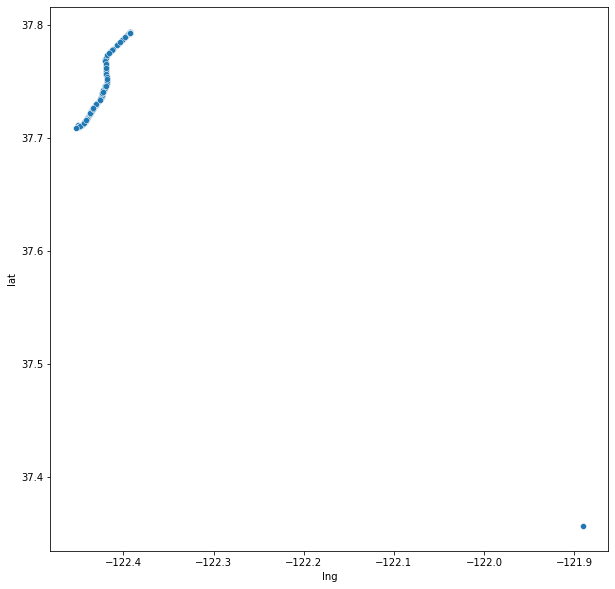

In [5]:
fig,ax=plt.subplots(figsize=(10,10))
sns.scatterplot(x=bus_stops['lng'],y=bus_stops['lat'])

There is an outlier in the bus stops may be it's wrong geocoded because it's outside San Francisco so I will drop it 

In [6]:
outlier_bus_stop=bus_stops[bus_stops['lng']==max(bus_stops['lng'])]
outlier_bus_stop

,Street_One,Street_Two,lat,lng
84,MISSION ST,12TH ST,37.35671,-121.89028


In [7]:
bus_stops=bus_stops.drop(84,axis=0)
bus_stops.shape

(118, 4)

now plotting the bus stops without the outlier

<AxesSubplot:xlabel='lng', ylabel='lat'>

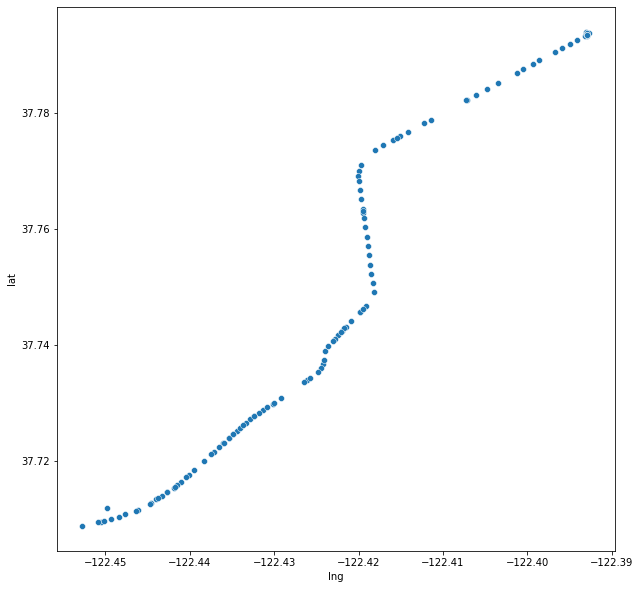

In [8]:
fig,ax=plt.subplots(figsize=(10,10))
sns.scatterplot(x=bus_stops['lng'],y=bus_stops['lat'])

Now I need to plot my data on a real interactive map I will use mapbox api which allows may to use plotly functions on a real map.

- Mapbox is a location data platform that provides various APIs for Maps, routing and navigation .
you can get a free token from <a href=https://www.mapbox.com> here </a>

In [9]:
#My access token
mapbox_access_token="Your access token"
px.set_mapbox_access_token(mapbox_access_token) #connecting using plotly express


In [10]:
#plotting the bus stops using plotly express and mapbox
fig=px.scatter_mapbox(bus_stops, lat="lat", lon="lng",
                        width=700,height=600,zoom=12)
fig.show()

# Explore Employees Data

In [11]:
employees=pd.read_csv("Employees_positions.csv")
employees=employees.drop(columns='Unnamed: 0',axis=1)
employees

,address,employee_id,lat,lng
0,"98 Edinburgh St, San Francisco, CA 94112, USA",206,37.72763,-122.42734
1,"237 Accacia St, Daly City, CA 94014, USA",2081,37.70418,-122.41582
2,"1835 Folsom St, San Francisco, CA 94103, USA",178,37.76793,-122.41510
3,"170 Cambridge St, San Francisco, CA 94134, USA",50,37.72966,-122.41972
4,"16 Roanoke St, San Francisco, CA 94131, USA",1863,37.73624,-122.43132
...,...,...,...,...
2186,"72 Topeka Ave, San Francisco, CA 94124, USA",980,37.73410,-122.40006
2187,"330 Oliver St, Daly City, CA 94014, USA",385,37.70531,-122.44851
2188,"94 W View Ave, San Francisco, CA 94134, USA",692,37.73079,-122.41717
2189,"1599 Geneva Ave, San Francisco, CA 94112, USA",1025,37.71244,-122.42960


I need to do simple data cleaning for employees data set 

- check if there is any employee lives outside california
- if there is duplicated addresses i need just to keep one them to reduce the calculations time
- if there is any wrong geocoded location I need to drop it 

In [12]:
#check if there is employees outside california
for i in employees['address']:
    if "CA" not in i:
        print(i)

In [13]:
employees.nunique()

address        1761
employee_id    2191
lat            1475
lng            1423
dtype: int64

There is duplicated addresses we need to take just one employee from employees who live in same location 

In [14]:
employees=employees.drop_duplicates(subset=['address'],ignore_index=True)
employees

,address,employee_id,lat,lng
0,"98 Edinburgh St, San Francisco, CA 94112, USA",206,37.72763,-122.42734
1,"237 Accacia St, Daly City, CA 94014, USA",2081,37.70418,-122.41582
2,"1835 Folsom St, San Francisco, CA 94103, USA",178,37.76793,-122.41510
3,"170 Cambridge St, San Francisco, CA 94134, USA",50,37.72966,-122.41972
4,"16 Roanoke St, San Francisco, CA 94131, USA",1863,37.73624,-122.43132
...,...,...,...,...
1756,"162 Accacia St, Daly City, CA 94014, USA",197,37.70579,-122.41569
1757,"72 Topeka Ave, San Francisco, CA 94124, USA",980,37.73410,-122.40006
1758,"330 Oliver St, Daly City, CA 94014, USA",385,37.70531,-122.44851
1759,"94 W View Ave, San Francisco, CA 94134, USA",692,37.73079,-122.41717


In [15]:
employees.describe()

,employee_id,lat,lng
count,1761.000000,1761.000000,1761.000000
mean,1085.467916,37.725873,-122.398242
std,634.725500,0.729998,1.174911
min,1.000000,7.131630,-122.451970
25%,529.000000,37.720290,-122.436600
50%,1082.000000,37.735400,-122.428740
75%,1633.000000,37.767850,-122.415550
max,2191.000000,37.798920,-73.125750


you can see from the maximum value of the lng and the minimum value of the lat that there are outliers or wrong geocoded addresses

- to solve this I will set the range of the latitude to **[37.5,38]** and the longitude to **[-123,-122]**


In [16]:
employees=employees[employees["lat"].between(37.5,38)][employees["lng"].between(-123,-121)].reset_index(drop=True)


C:\Users\msiik\AppData\Local\Temp\ipykernel_11072\3012535946.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



Now plot the employees locations with the bus stops locations

In [17]:
fig.add_scattermapbox(lat=employees["lat"], lon=employees["lng"],name="employees",hovertext=employees["employee_id"])
fig.add_scattermapbox(lat=bus_stops["lat"], lon=bus_stops["lng"],name="bus stops")


fig.show()

Now I need to split the employees into clusters. I will cluster the employees locations into 10 clusters then I will assign each cluster into the closest bus stop to their centroid.

**To do this I will use an Unsupervised learning method called herarchical clustering**

- I will use bottom-up herarchical clustering called agglomerative clustering.
    - `from the basis that all points are part of their own cluster and then groups the two closest points together, iteratively, until they are all part of a single cluster`

- This method is depending on affinity metric choosen and the linkage method
    - **affinity:** `I will use manhattan distance to calculate the distance between points it works as if there was grid like path between the points and that is what we have here.`
    
    - **linkage:** `it's the criterion of formation of this cluster I will use complete method as it defines the cluster distance between two clusters to be the maximum distance between their individual components I think that what I need here.`

In [18]:
cluster = AgglomerativeClustering(n_clusters=10,affinity="manhattan",linkage="average")
cluster.fit(employees[['lat','lng']])


AgglomerativeClustering(affinity='manhattan', linkage='average', n_clusters=10)

In [19]:
#add a new column called cluster that indicate the cluster for each employee
employees['cluster']=cluster.fit_predict(employees[['lat','lng']])
employees

,address,employee_id,lat,lng,cluster
0,"98 Edinburgh St, San Francisco, CA 94112, USA",206,37.72763,-122.42734,3
1,"237 Accacia St, Daly City, CA 94014, USA",2081,37.70418,-122.41582,6
2,"1835 Folsom St, San Francisco, CA 94103, USA",178,37.76793,-122.41510,0
3,"170 Cambridge St, San Francisco, CA 94134, USA",50,37.72966,-122.41972,3
4,"16 Roanoke St, San Francisco, CA 94131, USA",1863,37.73624,-122.43132,3
...,...,...,...,...,...
1754,"162 Accacia St, Daly City, CA 94014, USA",197,37.70579,-122.41569,6
1755,"72 Topeka Ave, San Francisco, CA 94124, USA",980,37.73410,-122.40006,1
1756,"330 Oliver St, Daly City, CA 94014, USA",385,37.70531,-122.44851,9
1757,"94 W View Ave, San Francisco, CA 94134, USA",692,37.73079,-122.41717,3


### Now visualizing the clusters of the employees 

In [20]:
fig=px.scatter_mapbox(employees, lat="lat", lon="lng",
                  width=700,height=600,zoom=12,color="cluster")
fig.add_scattermapbox(lat=bus_stops["lat"], lon=bus_stops["lng"],name="bus stops")

fig.show()

1- Now I have to calculate the centroid of each cluster <br>
2- I need to calculate the distance between the centroid and the bus stops<br>
3- get the minimum distance and this will be the best bus stop for this group<br>

In [21]:
centroids=[]
for i in range(10):
    cluster_employees=employees[employees['cluster']==i] #employees in the cluster
    centroids.append((np.sum(cluster_employees['lat'])/len(cluster_employees),np.sum(cluster_employees['lng'])/len(cluster_employees))) #get the centroid 
centroids=np.array(centroids)
centroids

array([[  37.769581  , -122.41877086],
       [  37.73499248, -122.40229782],
       [  37.74105167, -122.44851229],
       [  37.7303141 , -122.42832287],
       [  37.78523029, -122.39630743],
       [  37.79257108, -122.44350617],
       [  37.71005428, -122.41229186],
       [  37.7150659 , -122.43776181],
       [  37.74532033, -122.42270813],
       [  37.70663075, -122.44912505]])

## How will I calculate the distance is it manhattan distance again ?

Actually this will not be effiecnt because I need a real road distance like when you use google maps may be the location is near but you have to walk a lot because there no way to reach this location.<br>

so I need to calculate the geographic distance I will use open street maps (osm) to do this.

`osmnx is a Python package that lets you download geospatial data from OpenStreetMap `

In [22]:
# first Create graph from OSM within the boundaries of San Francisco City.
place= 'San Francisco, California, USA'
mode = 'walk' #we need walking streets     
optimizer = 'length' #we will use this to choose the shortest path depending on the length we could use the time instead
graph = ox.graph_from_place(place, network_type = mode) 


**distance_between_points** takes to geographic points(latitude and longitude) and calculates the length of the shortest path between them

- **osmnx.nearest_nodes:** takes the graph of san francisco we made and the first point latitude and longitude then returns the nearest node to this point.
- **networkx.shortest_path_length:** takes graph and the 2 nodes with the weight which is the length in this case and returns the shortes path length

In [23]:
def distance_between_points(p1, p2):

    orig_node = ox.nearest_nodes(graph ,p1[1],p1[0])
    dest_node = ox.nearest_nodes(graph,p2[1],p2[0])    
    length = nx.shortest_path_length(G=graph, source=orig_node, target=dest_node, weight=optimizer)
    return length


now get the best bus stop for each cluster

In [24]:

bus_pos=np.array(bus_stops[['lat','lng']])
optimal_bus_stops=[]
for i in range(len(centroids)):
    temp={}
    for j in range(len(bus_stops)):
       temp[j]=distance_between_points(centroids[i],bus_pos[j])
    optimal_bus_stops.append(min(temp,key=temp.get))#get the id of the nearest bus stop
    print("we choosed the bus stop for employees cluster number",i)

print("Done, The choosen bus stops ids are",optimal_bus_stops)
        

#this will take some time


we choosed the bus stop for employees cluster number 0
we choosed the bus stop for employees cluster number 1
we choosed the bus stop for employees cluster number 2
we choosed the bus stop for employees cluster number 3
we choosed the bus stop for employees cluster number 4
we choosed the bus stop for employees cluster number 5
we choosed the bus stop for employees cluster number 6
we choosed the bus stop for employees cluster number 7
we choosed the bus stop for employees cluster number 8
we choosed the bus stop for employees cluster number 9
Done, The choosen bus stops ids are [6, 51, 39, 17, 11, 69, 53, 29, 55, 23]


In [27]:
#saving a dataframe of the choosen bus stops
final_bus_stops=bus_stops.iloc[optimal_bus_stops]
final_bus_stops['cluster']=[i for i in range(10) ]


C:\Users\msiik\AppData\Local\Temp\ipykernel_11072\1817768262.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [28]:
fig=px.scatter_mapbox(employees, lat="lat", lon="lng",
                  width=700,height=600,zoom=12,color="cluster")

fig.add_trace(go.Scattermapbox(
        lat=final_bus_stops['lat'],
        lon=final_bus_stops['lng'],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=12,
            color='rgb(255, 0, 0)',
            opacity=0.8
        ),
        text=final_bus_stops['cluster'],
        hoverinfo='text',
        name="optimal"
    ))


fig.show()

# Adjustment

from the plot you can notice that some bus stops are closer to some employees than their cluster bus stop that is due to depending on the centroid to choose the bus stops so this bus stop is not good for all employees in this cluster.

we can fix that by comparing the distances between the employee and the other 10 bus stops and assign this employee to the nearest bus stop for him

In [29]:
# I will use manhattan distance in this adjustment due to the high time complexity of osmnx
  
distance_matrix=manhattan_distances(employees[['lat','lng']],final_bus_stops[['lat','lng']])
minimum=np.min(distance_matrix,axis=1) #minimum distance for each employee

new_clusters=[]
for i in range(distance_matrix.shape[0]):
    new_clusters.append(np.where(distance_matrix[i]==minimum[i])[0][0])

employees['cluster']=new_clusters
employees

,address,employee_id,lat,lng,cluster
0,"98 Edinburgh St, San Francisco, CA 94112, USA",206,37.72763,-122.42734,3
1,"237 Accacia St, Daly City, CA 94014, USA",2081,37.70418,-122.41582,7
2,"1835 Folsom St, San Francisco, CA 94103, USA",178,37.76793,-122.41510,0
3,"170 Cambridge St, San Francisco, CA 94134, USA",50,37.72966,-122.41972,3
4,"16 Roanoke St, San Francisco, CA 94131, USA",1863,37.73624,-122.43132,3
...,...,...,...,...,...
1754,"162 Accacia St, Daly City, CA 94014, USA",197,37.70579,-122.41569,7
1755,"72 Topeka Ave, San Francisco, CA 94124, USA",980,37.73410,-122.40006,1
1756,"330 Oliver St, Daly City, CA 94014, USA",385,37.70531,-122.44851,9
1757,"94 W View Ave, San Francisco, CA 94134, USA",692,37.73079,-122.41717,3


Now we can see that we assigned each employee to the nearest bus stop 

# Results

In [30]:
fig=px.scatter_mapbox(employees, lat="lat", lon="lng",
                  width=700,height=600,zoom=12,color="cluster")

fig.add_trace(go.Scattermapbox(
        lat=final_bus_stops['lat'],
        lon=final_bus_stops['lng'],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=12,
            color='rgb(255, 0, 0)',
            opacity=0.8
        ),
        text=final_bus_stops['cluster'],
        hoverinfo='text',
        name="optimal"
    ))


fig.show()

In [31]:

final_bus_pos=np.array(final_bus_stops[['lat','lng']])
walking_distance=[]
for i in range(len(employees)):
    walking_distance.append(distance_between_points(np.array(employees[['lat','lng']].iloc[i]),final_bus_pos[employees['cluster'][i]]))

employees['walking']=walking_distance


print("Done")
        

#this will take some time


Done


In [32]:
employees


,address,employee_id,lat,lng,cluster,walking
0,"98 Edinburgh St, San Francisco, CA 94112, USA",206,37.72763,-122.42734,3,571.216
1,"237 Accacia St, Daly City, CA 94014, USA",2081,37.70418,-122.41582,7,2724.922
2,"1835 Folsom St, San Francisco, CA 94103, USA",178,37.76793,-122.41510,0,570.832
3,"170 Cambridge St, San Francisco, CA 94134, USA",50,37.72966,-122.41972,3,1083.373
4,"16 Roanoke St, San Francisco, CA 94131, USA",1863,37.73624,-122.43132,3,1057.158
...,...,...,...,...,...,...
1754,"162 Accacia St, Daly City, CA 94014, USA",197,37.70579,-122.41569,7,2689.786
1755,"72 Topeka Ave, San Francisco, CA 94124, USA",980,37.73410,-122.40006,1,2705.191
1756,"330 Oliver St, Daly City, CA 94014, USA",385,37.70531,-122.44851,9,146.461
1757,"94 W View Ave, San Francisco, CA 94134, USA",692,37.73079,-122.41717,3,1119.621


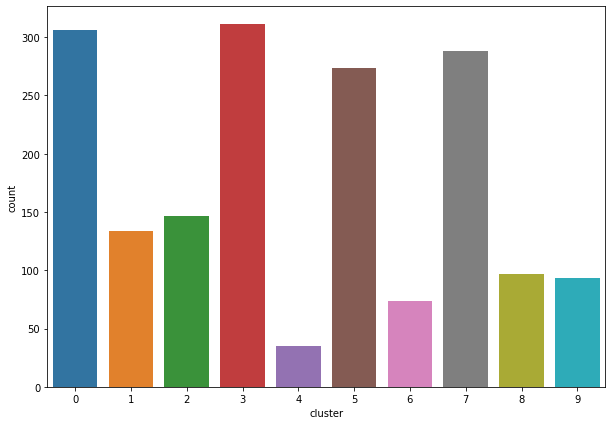

In [33]:
fig,ax=plt.subplots(figsize=(10,7))
sns.countplot(x=employees['cluster'])
plt.show()

In [34]:
np.sum(walking_distance)/len(walking_distance)

1396.5721239340537

There are people far from Mission ST. they will affect the average walking distance so I will check the median and the percentiles

In [35]:
print(employees['walking'].quantile(0.25))
print(employees['walking'].median())
print(employees['walking'].quantile(0.75))

547.108
989.3439999999999
1963.348


50% of the employees walk less than 989 metre

f:\siika\python\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<AxesSubplot:xlabel='walking', ylabel='Density'>

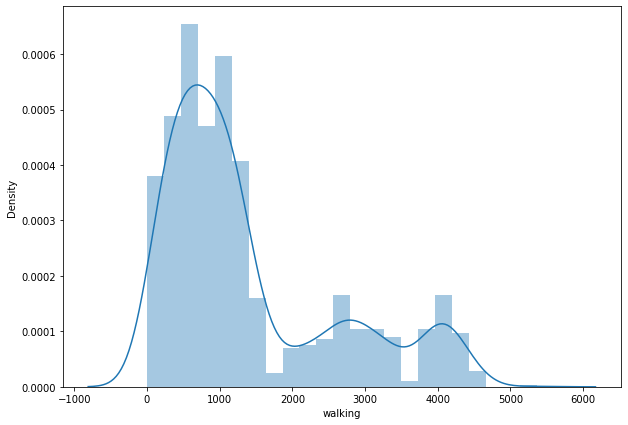

In [36]:
fig,ax=plt.subplots(figsize=(10,7))
sns.distplot(employees['walking'],ax=ax)

In [37]:
final_bus_stops

,Street_One,Street_Two,lat,lng,cluster
6,MISSION ST,ERIE ST,37.76907,-122.42004,0
51,MISSION ST,EUGENIA AVE,37.74222,-122.42208,1
39,MISSION ST,COTTER ST,37.72719,-122.43290,2
17,MISSION ST,TRUMBULL ST,37.73078,-122.42925,3
11,MISSION ST,ANTHONY ST,37.78838,-122.39933,4
69,MISSION ST,10TH ST,37.77528,-122.41591,5
53,MISSION ST,FRANCE AVE,37.72005,-122.43835,6
29,MISSION ST,GENEVA AVE,37.71639,-122.44100,7
55,MISSION ST,29TH ST,37.74408,-122.42092,8
23,MISSION ST,OLIVER ST,37.70955,-122.45052,9


In [ ]:
final_bus_stops.to_csv("final_results.csv")

<center>
<H2>SUMMARY</H2>
</center>

The Idea to get the best bus stops where depending on two things the first is to find 10 bus stops that is represent a group of employees to make sure that this bus stops cover all locations and to be accessible by all the employees the second thing is to not restrict each employee with the cluster bus stop we need to adjust clusters to set every employee to the nearest bus stop.

